# 动手学深度学习 第六章现代卷积神经网络竞赛
竞赛介绍: https://www.bilibili.com/video/BV1z64y1o7iz/?spm_id_from=333.999.0.0


竞赛地址: https://www.kaggle.com/c/classify-leaves

In [58]:
from typing import Union
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
from d2l import torch as d2l
from sklearn.model_selection import train_test_split


# ************************************************** substitute Tensor.__repr__
original_tensor_repr = torch.Tensor.__repr__
def custom_tensor_repr(self):
	return f"Shape{tuple(self.shape)}, {original_tensor_repr(self)}"
setattr(torch.Tensor, '__repr__', custom_tensor_repr)
# ************************************************** substitute Tensor.__repr__

# 构造数据集

In [59]:

class LeaveDataset(Dataset):
	"""
	读取数据集, 对数据集进行处理
	"""
	def __init__(self, dataset_path, split, split_path_df) -> None:
		"""
		Args:
			dataset_path: 数据集的路径
			split: 数据集的划分, 可以是'train', 'test', 'dev'
			split_path: 数据集的划分文件的路径, 或者是一个dataframe
			train_dev_split: 训练集和验证集的划分比例
		"""
		super().__init__()
		self.dataset_path = dataset_path
		self.split = split
		if isinstance(split_path_df, str):
			self.dataframe = pd.read_csv(split_path_df)
		else:
			self.dataframe = split_path_df


		if self.split == 'train':
			self.transform = transforms.Compose([
				transforms.Resize((42, 42)),
				transforms.ToTensor(),
				transforms.RandomHorizontalFlip(0.5),   # Data augmentation: 水平翻转
				transforms.RandomVerticalFlip(0.5)	# Data augmentation: 垂直翻转
			])
		else:
			self.transform = transforms.Compose([
				transforms.Resize((42, 42)),
				transforms.ToTensor(),
			])


		# 获取label2id和id2label
		label2id_path = os.path.join(self.dataset_path, "label2id.csv")
		df = pd.read_csv(label2id_path)
		label2id = {}
		for colum_name in df:
			# ! 这里十分重要, 一定要转换为int, 否则是numpy.int64, 会导致后面的错误
			label2id[colum_name] = int(df[colum_name][0])
		self.label2id = label2id
		id2label_path = os.path.join(self.dataset_path, "id2label.csv")
		df = pd.read_csv(id2label_path)
		id2label = {}
		for colum_name in df:
			id2label[int(colum_name)] = df[colum_name][0]	# type: ignore
		self.id2label = id2label
		
		
		# 构建数据
		self.data = self.build_data()

	
	def __getitem__(self, index) -> Union[tuple[torch.Tensor, str], tuple[torch.Tensor,]]:
		if self.split in ['train', 'dev']:
			image, label = self.data[index]
			return image, label
		else:
			image = self.data[index]
			return image


	def __len__(self):
		return len(self.data)
	

	def build_data(self):
		"""
		读取图片, 对图片进行处理
		返回一个列表, 列表中的每个元素是一个元组, 元组的第一个元素是图片, 第二个元素是label (仅训练集)
		"""
		num_label = len(self.label2id)

		data = []
		bar = tqdm(total=len(self.dataframe), desc="Building data")
		# *** 构建训练集数据
		if self.split in ['train', 'dev']:
			for image_path, label in zip(self.dataframe['image'], self.dataframe['label']):
				image_path = os.path.join(self.dataset_path, image_path)
				image = Image.open(image_path)
				image = self.transform(image)
				data.append((image, self.label2id[label]))
				bar.update(1)
		# *** 构建测试集数据, 测试集数据没有标签
		else:
			for image_path in self.dataframe['image']:
				image_path = os.path.join(self.dataset_path, image_path)
				image = Image.open(image_path)
				image = self.transform(image)
				data.append((tuple([image])))
				bar.update(1)
		
		return data
	

# 构造网络

In [60]:

class Residual(nn.Module):
	def __init__(self, input_channel, output_channel, use_1x1_conv=False, stride=1, **kwargs) -> None:
		super().__init__()
		self.conv1 = nn.Conv2d(input_channel, output_channel, 3, padding=1, stride=stride)
		self.batch_norm1 = nn.BatchNorm2d(output_channel)
		self.conv2 = nn.Conv2d(output_channel, output_channel, 3)
		self.batch_norm2 = nn.BatchNorm2d(output_channel)

		if use_1x1_conv:
			self.conv3 = nn.Conv2d(input_channel, output_channel, 1, stride=stride)
		else:
			self.conv3 = None
		
	def forward(self, X):
		Y = F.relu(self.batch_norm1(self.conv1(X)))
		Y = self.batch_norm2(Y)

		if self.conv3:
			X = self.conv3(X)
		
		return F.relu(Y + X)

				
class ResNet(nn.Module):
	def __init__(self, *args, **kwargs) -> None:
		super().__init__(*args, **kwargs)

		b1 = nn.Sequential(
			nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
			nn.BatchNorm2d(64), nn.ReLU(),
			nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
		)
		b2 = nn.Sequential(*self.resnet_block(64, 64, 2, first_block=True))
		b3 = nn.Sequential(*self.resnet_block(64, 128, 2))
		b4 = nn.Sequential(*self.resnet_block(128, 256, 2))
		b5 = nn.Sequential(*self.resnet_block(256, 512, 2))

		self.model = nn.Sequential(
			b1, b2, b3, b4, b5,
			nn.AdaptiveAvgPool2d((1, 1)),
			nn.Flatten(),
			nn.Linear(512, 176)
		)
	
	def forward(self, X):
		return self.model(X)
	

	@staticmethod
	def resnet_block(input_channel, num_channels, num_residuals, first_block=False):
		"""
		构建resnet块

		Args:
			input_channel: 输入通道数
			num_channels: 输出通道数
			num_residuals: resnet块中的残差块数
			first_block: 是否是第一个块
		"""
		blk = []
		for i in range(num_residuals):
			if i == 0 and not first_block:
				# 第一个残差块将通道数翻倍, 长宽减半
				blk.append(Residual(input_channel, num_channels, use_1x1_conv=True, stride=2))
			else:
				# 之后的残差块不改变长宽和通道数 (如果是ResNet的first_block, 那么第一个残差快也不改变长宽和通道数)
				blk.append(Residual(num_channels, num_channels))
		return blk

# 训练函数

In [61]:

def compute_metrics(y_hat, y):
    """Compute the number of correct predictions.

    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))


def train(model:nn.Module, train_loader, test_loader, num_epochs, learning_rate, weight_decay=None, device=None):
	"""
	"""
	# 参数初始化
	def init_weight(layer):
		if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
			nn.init.xavier_uniform_(layer.weight)
	model.apply(init_weight)

	# 定义损失函数, 优化器
	loss = nn.CrossEntropyLoss()
	if weight_decay:
		optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
	else:
		optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

	# 绘图
	num_batches = len(train_loader)

	# 确定模型以及数据的位置
	if not device:
		device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
	model.to(device)

	epoch_bar = tqdm(total=num_epochs, position=0, leave=True, desc="Training")
	for epoch in range(num_epochs):
		# metric中, 0表示训练的loss, 1表示测试的loss, 2表示测试的准确率
		metric = d2l.Accumulator(3)
		model.train()
		for i, (X, y) in enumerate(train_loader):
			X, y = X.to(device), y.to(device)
			optimizer.zero_grad()
			y_hat = model(X)
			l = loss(y_hat, y)
			l.backward()
			optimizer.step()
			with torch.no_grad():
				metric.add(l*X.shape[0], compute_metrics(y_hat, y), X.shape[0])
			train_l = metric[0] / metric[2]
			train_acc = metric[1] / metric[2]
		test_acc = d2l.evaluate_accuracy_gpu(model, test_loader)
		epoch_bar.update(1)
		epoch_bar.set_description(f"Training on Epoch {epoch + 1}, test_acc:{test_acc:.3f}, train_acc:{train_acc:.3f}, train_loss:{train_l:.3f}")	# type: ignore

	print(f"Finally test acc is {test_acc}")	# type: ignore


# 其他函数

In [62]:

def inspect_dataset(dataset):
	"""
	查看数据集
	"""
	import numpy as np
	from matplotlib import pyplot as plt
	import random

	index = random.randint(0, 1000)
	id2label = dataset.id2label
	temp_tensor = dataset[index][0]
	temp_label = dataset[index][1]

	temp_array = temp_tensor.numpy()
	temp_array = np.transpose(temp_array, (1, 2, 0))

	plt.imshow(temp_array)
	print(index)
	print(id2label[temp_label])

# 开始训练

In [63]:

# ************************************************** 超参数
# 图像的长和宽是224, 224
dataset_path = "./dataset/classify_leaves"
# split文件中同时记录了label
train_split = "./dataset/classify_leaves/train.csv"
test_split = "./dataset/classify_leaves/test.csv"
batch_size = 128
train_ratio = 0.8
learning_rate = 1e-2
num_epochs = 50
# ************************************************** 超参数

In [64]:
train_split_dataframe = pd.read_csv(train_split)
train_df, dev_df = train_test_split(train_split_dataframe, train_size=train_ratio, shuffle=False)
train_dataset = LeaveDataset(dataset_path, 'train', train_df)
dev_dataset = LeaveDataset(dataset_path, 'dev', dev_df)
test_dataset = LeaveDataset(dataset_path, 'test', test_split)

train_loader = DataLoader(train_dataset, batch_size, True, num_workers=4)
dev_loader = DataLoader(dev_dataset, batch_size, True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size, True, num_workers=4)

Building data: 100%|██████████| 8800/8800 [00:10<00:00, 850.80it/s]


481
cryptomeria_japonica


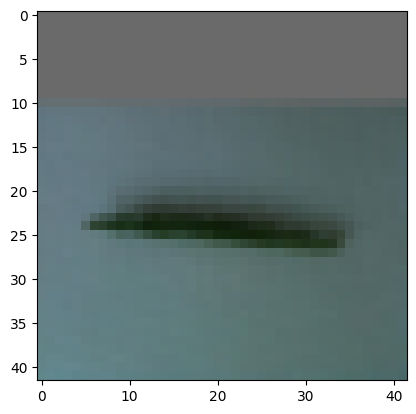

In [65]:
inspect_dataset(train_dataset)

In [67]:
model = ResNet()
train(model, train_loader, dev_loader, num_epochs, learning_rate)

Training on Epoch 50, test_acc:0.434, train_acc:0.850, train_loss:0.459: 100%|██████████| 50/50 [02:39<00:00,  3.18s/it]

Finally test acc is 0.43421411059656767
